In [10]:
from util_all import * 

## Loading the DATA

In [11]:
# Loading all the data from Matlab file
data=scipy.io.loadmat(f'data/features_matrix.mat')
labels= np.squeeze(data['labels'])
labels_for_ML = 10**labels
Y = pd.DataFrame({'y': labels_for_ML})
features = data['features']
cycling_conditions = data['cycling_conditions']
features_names0 = data['features_names']
features_names = [subarray[0] for subarray in features_names0[0]]
cycling_conditions_names0 = data['cycling_conditions_names']
cycling_conditions_names = [subarray[0] for subarray in cycling_conditions_names0[0]]

#Concatenating all features in one big array of dim num_cells x num_features
all_features = features[:,:,0]
for i in range(1,3):
    all_features=np.concatenate((all_features,features[:,:,i]),axis=1)
    
# Creating features names (handles for features df column and metadata df )
classes = ['charge', 'full', 'discharge']
all_features_names = [my_class+'_'+s  for my_class in classes for s in features_names]

# Creating the Features Dataframes
all_features_df = pd.DataFrame(all_features, columns = all_features_names)
cycling_conditions_df = pd.DataFrame(cycling_conditions, columns = cycling_conditions_names)

In [12]:
#creating metadata Dataframe for all features
features_metadata_df = pd.DataFrame(index = all_features_names)
for name, row in features_metadata_df.iterrows():
    features_metadata_df.loc[name,'type']=get_feature_type(name)
    features_metadata_df.loc[name,'class']=get_feature_class(name)
    features_metadata_df.loc[name,'stream']=get_feature_stream(name)
    features_metadata_df.loc[name,'num_cycles_needed']=int(name[name.find('y')+9:name.find('y')+12]) 
    my_min, my_max = get_min_max_percentile(name)
    features_metadata_df.loc[name,'min_percentile']=my_min
    features_metadata_df.loc[name,'max_percentile']=my_max
    features_metadata_df.loc[name,'Pearson']=abs(pearsonr(all_features_df[name],labels_for_ML)[0])
    features_metadata_df.loc[name,'Log_Pearson']=abs(pearsonr(all_features_df[name],labels)[0])
    
#creating metadata Dataframe for cycling conditions
cycling_conditions_metadata_df = pd.DataFrame(data = [0,0,0,0],index=cycling_conditions_names,columns=['class'])
for name, row in cycling_conditions_metadata_df.iterrows():
    cycling_conditions_metadata_df.loc[name,'Pearson']=abs(pearsonr(cycling_conditions_df[name],labels_for_ML)[0])
    cycling_conditions_metadata_df.loc[name,'Log_Pearson']=abs(pearsonr(cycling_conditions_df[name],labels)[0])
    


#### Test wrapper - Iterating through all sub datasets for all test splits

#### Prepping the data 

In [13]:
types =['charge','full','discharge']
time_regions = [1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

#Getting a list of 3x16 datasets, 1 per type and time_region
metadata_per_class_per_TR = [features_metadata_df[(features_metadata_df['type']==x)&(features_metadata_df['num_cycles_needed']==y)] for x in types for y in time_regions]  
datasets = [all_features_df[meta_x.index.values.tolist()] for meta_x in metadata_per_class_per_TR]

#creating handles for which dataset is which:
my_dataset_order = np.array([[x,y] for x in types for y in time_regions])
my_types = my_dataset_order[:,0]
my_time_regions = my_dataset_order[:,1]

#### Iterating through 10 TTS, and all datasets

In [14]:
nb_entries = len(time_regions)*len(types)
ENet_TTS = np.empty((nb_entries,6,0))
RF_TTS = np.empty((nb_entries,6,0))

In [ ]:
for TTS in range (10):
    print(f'doing TTS {TTS} -------------------------')
    
    #Initializing results arrays for this train/test split
    ENet_results = np.empty((0,6))
    RF_results =  np.empty((0,6))
    for i in range(len(datasets)):
        print(i)
        X = datasets[i]

        ## Splitting into train (train/val) and test sets
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=TTS)

        ## Make unified dataframes for train and test
        df_train = Y_train.join(X_train)
        df_test = Y_test.join(X_test)

        Y_col = ['y']
        X_col =  X.columns.tolist()

        #finding best ENet
        warnings.simplefilter('ignore')
        opt_model, X_train_scaled, Y_train_scaled, X_scaler, Y_scaler = make_cv_model_object(df_train,
                                         X_col=X_col,Y_col=Y_col,
                                        cv_splits = 10,                                       
                                         model=ElasticNet(random_state=25),
                                         model_hyperparams={'alpha': [0.00001, 0.00005,0.0001,0.001,0.005,0.01,0.02,0.03,0.04,0.1],
                                                            'l1_ratio':[0.2,0.3,0.4,0.5,0.6,0.7,0.8]})

        #Recover best ENet and train it on the totality of X_train:
        best_ENet= opt_model.best_estimator_
        best_ENet.fit(X_train_scaled,Y_train_scaled.values.ravel())

        ENet_iter_result = plot_train_test_model_predictions(best_ENet,
                                              X_train_scaled = X_train_scaled, X_test = X_test, X_scaler = X_scaler, 
                                             Y_train = Y_train, Y_test = Y_test, Y_scaler = Y_scaler,
                                                X_col=X_col,Y_col=['y'],
                                             plot_bounds = [0,2000], plot=False)[0:6]

        ENet_iter_result = np.array(ENet_iter_result).reshape((1,-1))
        ENet_results = np.append(ENet_results,ENet_iter_result,axis=0)

        #finding best RF
        opt_model, X_train_scaled, Y_train_scaled, X_scaler, Y_scaler = make_cv_model_object(df_train,
                                                 Y_col=Y_col,
                                                 X_col=X_col,
                                                cv_splits = 10,                                       
                #                                  split_lists=split_lists,
                                                 model=RandomForestRegressor(random_state=0),
                                                 model_hyperparams={'n_estimators': [40,80,160],
                                                                    'min_samples_leaf':[2,4],#[1,2,4,8]
                                                                    'min_samples_split':[2,4,8]})

        #Best RF:
        best_RF= opt_model.best_estimator_
        best_RF.fit(X_train_scaled,Y_train_scaled.values.ravel())

        RF_iter_result= plot_train_test_model_predictions(best_RF,
                                              X_train_scaled = X_train_scaled, X_test = X_test, X_scaler = X_scaler, 
                                             Y_train = Y_train, Y_test = Y_test, Y_scaler = Y_scaler,
                                                X_col=X_col,Y_col=['y'],
                                             plot_bounds = [0,2000], plot=False)[0:6]

        RF_iter_result= np.array(RF_iter_result).reshape((1,-1))
        RF_results = np.append(RF_results,RF_iter_result,axis=0)
        
    #for each Train Test split, we append the Xx6 result array into the third dim of main result array    
    ENet_results = np.expand_dims(ENet_results,axis=-1)
    ENet_TTS = np.concatenate([ENet_TTS,ENet_results],axis=2)
    RF_results = np.expand_dims(RF_results,axis=-1)
    RF_TTS = np.concatenate([RF_TTS,RF_results],axis=2)
    

In [16]:
# Extracting mean and std across all 10 train test splits
ENet_TTS_means = np.mean(ENet_TTS,axis =2)
ENet_TTS_std =np.std(ENet_TTS,axis=2)

RF_TTS_means = np.mean(RF_TTS,axis =2)
RF_TTS_std =np.std(RF_TTS,axis=2)

# Constructing digestible datasets
def construct_df (array,my_columns,my_time_regions,my_types):
    df = pd.DataFrame(array,columns=my_columns)
    df['type']=my_types
    df['time_region']=my_time_regions
    return df

my_columns = ['train MAPE','test MAPE','train RMSE','test RMSE','train MAE','test MAE']
ENet_TTS_means_df = construct_df(ENet_TTS_means,my_columns,my_time_regions,my_types)
ENet_TTS_std_df = construct_df(ENet_TTS_std,my_columns,my_time_regions,my_types)

RF_TTS_means_df = construct_df(RF_TTS_means,my_columns,my_time_regions,my_types)
RF_TTS_std_df = construct_df(RF_TTS_std,my_columns,my_time_regions,my_types)

In [17]:
RF_TTS_std_df.head()

,train MAPE,test MAPE,train RMSE,test RMSE,train MAE,test MAE,type,time_region
0,0.015651,0.036680,22.016503,42.216604,11.308174,24.603799,charge,1
1,0.013001,0.033678,20.759456,40.873410,10.064518,22.953780,charge,10
2,0.013123,0.040049,17.340702,68.750396,9.817447,29.825128,charge,20
3,0.004341,0.033557,5.641943,35.843925,2.587867,21.548170,charge,30
4,0.011470,0.032480,18.133919,47.221675,9.190905,26.438302,charge,40


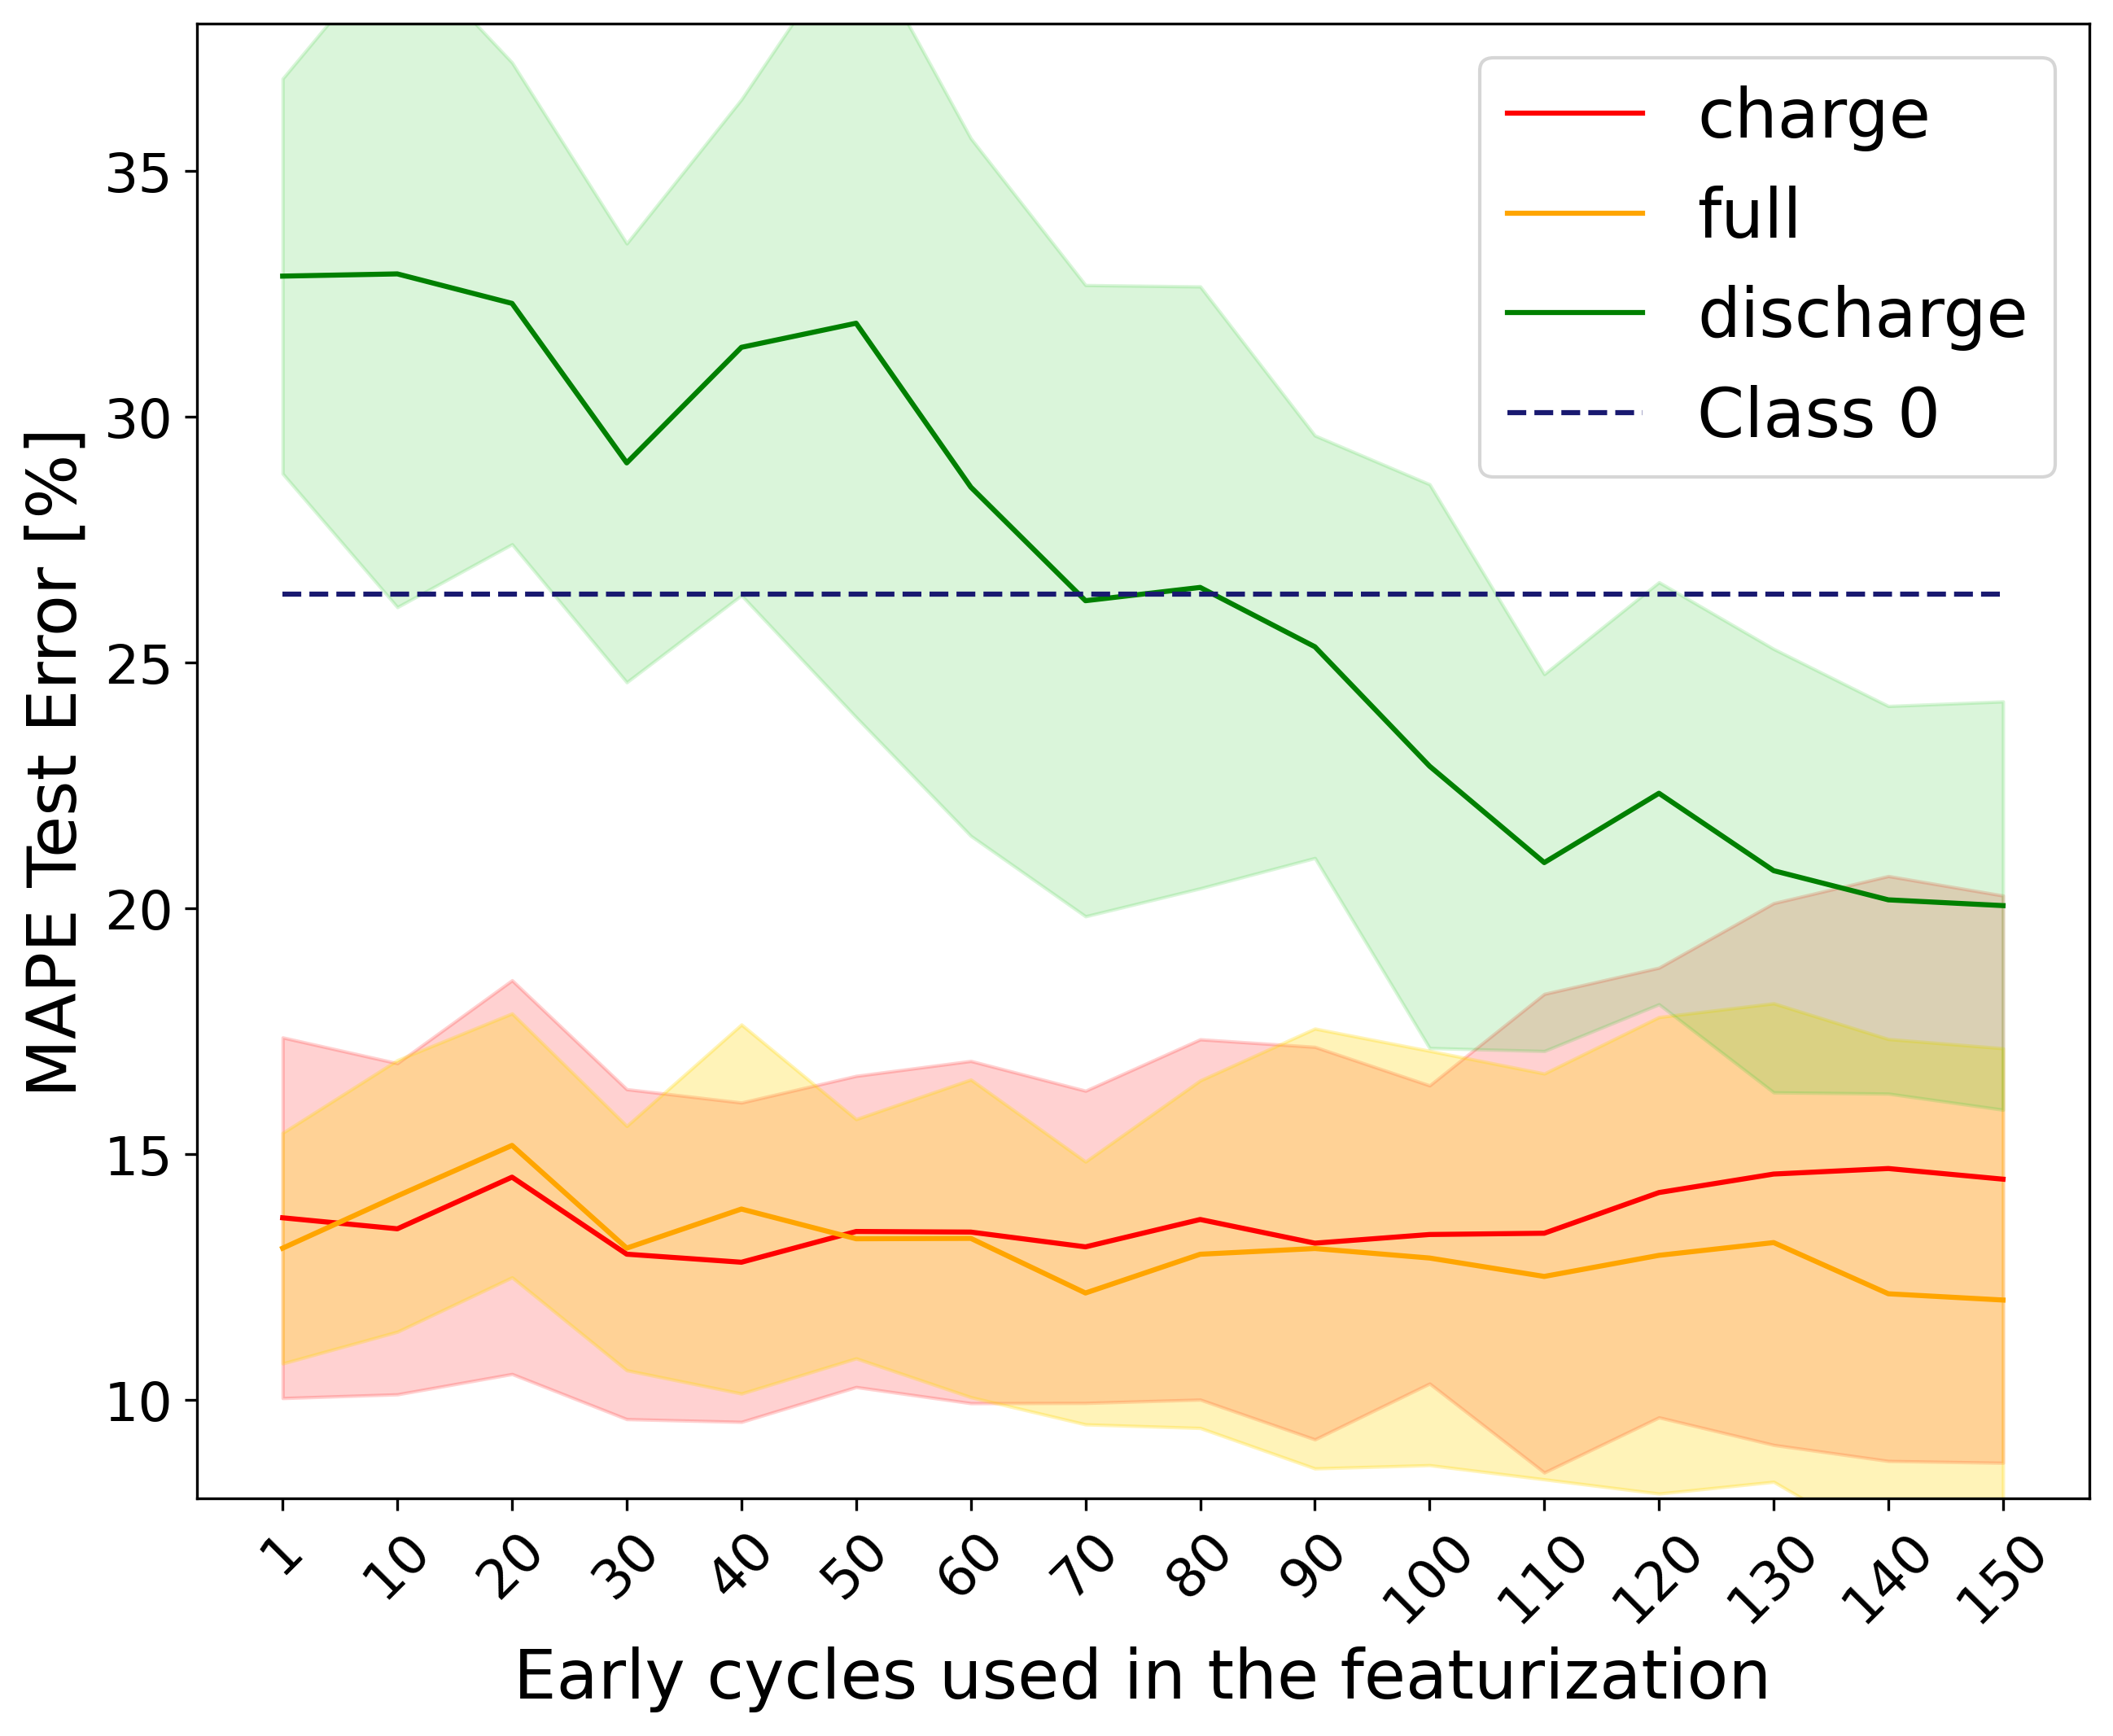

In [19]:
### PLOTTING PAPER FIGURE 3

#hyperparam for plot
axisfontsize =20
tickfontsize =16
titlefontsize = 24

#Selecting data to plot:
models = ['ENet','RF']
model_names =['Elastic Net','Random Forest']
errors =['MAPE']#,'RMSE','MAE']
colors =['red','orange','green']
stdcolors =['red','gold','limegreen']
stdcolors2 =['orangered','navajowhite','darkseagreen']
class0 = np.array([[0.264,0.264]])

#Plotting results
fig= plt.figure(figsize=(10,8),dpi=300)
error = 'test '+errors[0]
col=1 #from the copy-paste from above
model = models[col]
model_name = model_names[col]
data =eval(model+'_TTS_means_df')
std = eval(model+'_TTS_std_df')

for idx,x in enumerate(types):
    meantoplot = data[data['type']==x]
    stdtoplot =std[std['type']==x]

    plt.plot(meantoplot['time_region'],100*meantoplot[error],label=x,color = colors[idx])
    #plotting different color shades for the STD deviation.
    if x=='full':
        plt.fill_between(meantoplot['time_region'],100*(meantoplot[error]-stdtoplot[error]),100*(meantoplot[error]+stdtoplot[error]),color=stdcolors[idx], alpha=0.28)
    else:
        plt.fill_between(meantoplot['time_region'],100*(meantoplot[error]-stdtoplot[error]),100*(meantoplot[error]+stdtoplot[error]),color=stdcolors[idx], alpha=0.18)
#         axs[col].fill_between(meantoplot['time_region'],lowCItoplot[error],highCItoplot[error],color=stdcolors[idx], alpha=0.1)

plt.plot([0,15],100*class0[0,:],'--',c='midnightblue', linewidth = 1.5, label = 'Class 0')
plt.legend(fontsize=axisfontsize)
plt.ylim([8,38])
plt.xlabel("Early cycles used in the featurization",fontsize = axisfontsize)
plt.ylabel(f"{errors[0]} Test Error [%]",fontsize = axisfontsize)
plt.tick_params(axis = 'y', labelsize= tickfontsize, rotation = 0)
plt.tick_params(axis = 'x', labelsize= tickfontsize, rotation = 45)
# plt.title(f' {errors[0]} error decay - {model_name}', fontsize = titlefontsize)
